In [3]:
from model_xray.zenml.pipelines.data_creation.data_classes import ModelRepos
from model_xray.zenml.pipelines.data_creation.model_attack import embed_payload_into_pretrained_weights_pipeline
from model_xray.config_classes import EmbedPayloadConfig, EmbedType, GrayscaleLastMBytesConfig, ImageRepConfig, ImageType, PayloadType, XLSBAttackConfig
from model_xray.utils.image_rep_utils import image_rep_map

from model_xray.zenml.pipelines.data_creation.image_representation import image_representation_from_attacked_pretrained_pipeline


pretrained_model_name = "MobileNet"
pretrained_model_repo = ModelRepos.KERAS

embedding_config = EmbedPayloadConfig(
    embed_type=EmbedType.X_LSB_ATTACK_FILL,
    embed_proc_config=XLSBAttackConfig(
        x=8,
        fill=True,
        msb=False,
        payload_type=PayloadType.RANDOM,
    )
)

res = image_representation_from_attacked_pretrained_pipeline(
    pretrained_model_name=pretrained_model_name,
    pretrained_model_repo=pretrained_model_repo,
    embed_payload_config=embedding_config,
    image_rep_config=ImageRepConfig(
        image_type=ImageType.GRAYSCALE_LAST_M_BYTES,
        image_rep_config=GrayscaleLastMBytesConfig(m=4)
    )
)

Starting embedding random payload into MobileNet pretrained weights using x_lsb_attack_fill embedding with x=8
Initiating a new run for the pipeline: image_representation_from_attacked_pretrained_pipeline.
Executing a new run.
Using user: default
Using stack: custom-stack
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
  artifact_store: custom_artifact_store_local
Dashboard URL: http://127.0.0.1:8237/runs/0ee62796-714b-4cfa-9c79-e9d2be37c33a
Caching enabled explicitly for fetch_pretrained.
Using cached version of fetch_pretrained.
Step fetch_pretrained has started.
Caching enabled explicitly for extract_weights.
Using cached version of extract_weights.
Step extract_weights has started.
Using cached version of embed_payload_into_weights.
Step embed_payload_into_weights has started.
Using cached version of create_image_representation.
Step create_image_representation has started.
Pipeline run has finished in 1.251s.


In [6]:
# res.steps.keys()
im = res.steps["create_image_representation"].output.load()
im.shape
# im = 

(1, 4126, 4126)

In [1]:
from model_xray.config_classes import ClassificationMetricConfig, DatasetConfig
from model_xray.zenml.pipelines.model_evaluation.eval_model import evaluate_pretrained_model

from model_xray.config_classes import ClassificationMetric, ClassificationMetricConfig, DatasetConfig, DatasetType, EmbedPayloadConfig, ImageDatasetConfig, ModelRepos

results = {}

for x in range(0, 24, 3):
    response = evaluate_pretrained_model(
        model_repo=ModelRepos.KERAS,
        pretrained_model_name='MobileNet',

        ds_name='imagenet12',
        ds_config=DatasetConfig.ret_img_ds_config(image_size=(224, 224), take=100),

        requested_metrics=[
            ClassificationMetricConfig.ret_top_k_categorical_accuracy_config(k=1),
        ],
        embed_payload_config=EmbedPayloadConfig.ret_x_lsb_attack_fill_config(x=x) if x > 0 else None
    )

    results[x] = response.steps["calc_metrics"].output.load()

2024-08-17 18:30:03.446869: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 18:30:03.469402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 18:30:03.469418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 18:30:03.469433: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 18:30:03.473694: I tensorflow/core/platform/cpu_feature_g

PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.
Initiating a new run for the pipeline: evaluate_pretrained_model.
Executing a new run.
Using user: default
Using stack: custom-stack
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
  artifact_store: custom_artifact_store_local
Dashboard URL: http://127.0.0.1:8237/runs/40ab2180-d47d-4d11-9776-a96218bb9294
Caching enabled explicitly for fetch_pretrained.
Using cached version of fetch_pretrained.
Step fetch_pretrained has started.
Using cached version of get_val_ds.
Step get_val_ds has started.
Using cached version of eval_model.
Step eval_model has started.
Using cached version of extract_y_true.
Step extract_y_true has started.
Using cached version of calc_metrics.
Step calc_metrics has started.
Pipeline run has finished in 2.093s.
Starting embedding random payload into MobileNet pretrained weights using x_lsb_attack_fill embedding with x=3
Initiating a new run for the pipeline: evaluate_

In [2]:
accs = [v[ClassificationMetricConfig.ret_top_k_categorical_accuracy_config(k=1)] for k,v in results.items()]
print(results.keys())
accs

dict_keys([0, 3, 6, 9, 12, 15, 18, 21])


[0.69625,
 0.69625,
 0.69625,
 0.6965625,
 0.6953125,
 0.6978125,
 0.6859375,
 0.0034375]

In [8]:
import numpy as np

from model_xray.zenml.pipelines.data_creation.fetch_pretrained import fetch_pretrained_model_and_extract_weights
from model_xray.config_classes import ModelRepos
from model_xray.zenml.pipelines.data_creation.model_attack import embed_payload_into_pretrained_weights_pipeline

model_repo=ModelRepos.KERAS
pretrained_model_name = 'MobileNet'

unmodified_weights_reponse = fetch_pretrained_model_and_extract_weights(
    model_repo=model_repo,
    pretrained_model_name=pretrained_model_name
)

unmodified_weights = np.array([unmodified_weights_reponse.steps["extract_weights"].output.load()])

print(unmodified_weights.shape)

eq_amounts = {}

for i in range(0, 24, 3):
    if i == 1:
        continue
    ew_response = embed_payload_into_pretrained_weights_pipeline(
        pretrained_model_repo=model_repo,
        pretrained_model_name=pretrained_model_name,
        embed_payload_config=EmbedPayloadConfig.ret_x_lsb_attack_fill_config(x=i)
    )

    modified_weights = np.array([ew_response.steps["embed_payload_into_weights"].output.load()])

    eq_true = np.equal(unmodified_weights, modified_weights) == True
    eq_amounts[i] = np.count_nonzero(eq_true, axis=1)

Initiating a new run for the pipeline: fetch_pretrained_model_and_extract_weights.
Executing a new run.
Using user: default
Using stack: custom-stack
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
  artifact_store: custom_artifact_store_local
Dashboard URL: http://127.0.0.1:8237/runs/e9ed65d3-91e6-4f67-8d19-775b1efa4cad
Caching enabled explicitly for fetch_pretrained.
Using cached version of fetch_pretrained.
Step fetch_pretrained has started.
Caching enabled explicitly for extract_weights.
Using cached version of extract_weights.
Step extract_weights has started.
Pipeline run has finished in 1.128s.
(1, 4253864)
Starting embedding random payload into MobileNet pretrained weights using x_lsb_attack_fill embedding with x=1
Initiating a new run for the pipeline: embed_payload_into_pretrained_weights_pipeline.
Executing a new run.
Using user: default
Using stack: custom-stack
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
  artifact_store:

In [9]:
for i in range(1, 24, 3):
    print(f'\tLSB {i}: min: {np.min(eq_amounts[i])}, max: {np.max(eq_amounts[i])}, mean: {np.mean(eq_amounts[i])}')

	LSB 1: min: 2126529, max: 2126529, mean: 2126529.0
	LSB 2: min: 1062044, max: 1062044, mean: 1062044.0
	LSB 3: min: 531524, max: 531524, mean: 531524.0
	LSB 4: min: 266456, max: 266456, mean: 266456.0
	LSB 5: min: 132637, max: 132637, mean: 132637.0
	LSB 6: min: 65960, max: 65960, mean: 65960.0
	LSB 7: min: 33416, max: 33416, mean: 33416.0
	LSB 8: min: 16702, max: 16702, mean: 16702.0
	LSB 9: min: 8267, max: 8267, mean: 8267.0
	LSB 10: min: 4118, max: 4118, mean: 4118.0
	LSB 11: min: 2056, max: 2056, mean: 2056.0
	LSB 12: min: 1020, max: 1020, mean: 1020.0
	LSB 13: min: 529, max: 529, mean: 529.0
	LSB 14: min: 295, max: 295, mean: 295.0
	LSB 15: min: 116, max: 116, mean: 116.0
	LSB 16: min: 76, max: 76, mean: 76.0
	LSB 17: min: 32, max: 32, mean: 32.0
	LSB 18: min: 13, max: 13, mean: 13.0
	LSB 19: min: 13, max: 13, mean: 13.0
	LSB 20: min: 4, max: 4, mean: 4.0
	LSB 21: min: 2, max: 2, mean: 2.0
	LSB 22: min: 1, max: 1, mean: 1.0
	LSB 23: min: 0, max: 0, mean: 0.0


In [8]:
results[0][ClassificationMetricConfig.ret_top_k_categorical_accuracy_config(k=1)]

0.69625

In [1]:
from model_xray.zenml.pipelines.data_creation.image_representation import image_representation_from_pretrained_pipeline
import numpy as np

from model_xray.zenml.pipelines.data_creation.fetch_pretrained import fetch_pretrained_model_and_extract_weights
from model_xray.config_classes import *
from model_xray.zenml.pipelines.data_creation.model_attack import embed_payload_into_pretrained_weights_pipeline

pretrained_model_name = "InceptionResNetV2"
pretrained_model_repo = ModelRepos.KERAS

embedding_config = EmbedPayloadConfig(
    embed_type=EmbedType.X_LSB_ATTACK_FILL,
    embed_proc_config=XLSBAttackConfig(
        x=8,
        fill=True,
        msb=False,
        payload_type=PayloadType.RANDOM,
    )
)

im_res = image_representation_from_pretrained_pipeline(
    pretrained_model_name=pretrained_model_name,
    pretrained_model_repo=pretrained_model_repo,
    embed_payload_config=embedding_config,

    image_rep_config=ImageRepConfig(
        image_type=ImageType.GRAYSCALE_FOURPART,
        image_rep_config=None
    )
)

im = im_res.steps["create_image_representation"].output.load()
im.shape

PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.
Starting embedding random payload into InceptionResNetV2 pretrained weights using x_lsb_attack_fill embedding with x=8
Initiating a new run for the pipeline: image_representation_from_pretrained_pipeline.
Executing a new run.
Using user: default
Using stack: custom-stack
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
  artifact_store: custom_artifact_store_local
Dashboard URL: http://127.0.0.1:8237/runs/488aeeb2-6275-43ee-aee7-b4507f3d0b18
Caching enabled explicitly for fetch_pretrained.
Using cached version of fetch_pretrained.
Step fetch_pretrained has started.
Caching enabled explicitly for extract_weights.
Using cached version of extract_weights.
Step extract_weights has started.
Caching enabled explicitly for embed_payload_into_weights.
Using cached version of embed_payload_into_weights.
Step embed_payload_into_weights has started.
Caching enabled explicitly for create_image_repres

(1, 14950, 14950)

In [1]:
from zenml.client import Client

artifact = Client().get_artifact_version('60968deb-6a43-40f4-aaa2-11b22f7cd81e')
# artifact = Client().get_artifact_version('2b0936d4-5e10-4c6b-b505-e7c0f724bd6d')
img = artifact.load()

img.shape

(100, 100)

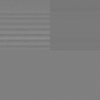

In [3]:
from PIL import Image

Image.fromarray(img)

In [1]:
from model_xray.zenml.pipelines.data_creation.image_representation import image_representation_from_pretrained_pipeline, preprocessed_image_representation_from_pretrained_pipeline
import numpy as np

from model_xray.zenml.pipelines.data_creation.fetch_pretrained import fetch_pretrained_model_and_extract_weights
from model_xray.config_classes import *
from model_xray.zenml.pipelines.data_creation.model_attack import embed_payload_into_pretrained_weights_pipeline

preprocessed_image_representation_from_pretrained_pipeline(
    pretrained_model_repo=ModelRepos.KERAS,
    pretrained_model_name='MobileNet',

    image_rep_config=ImageRepConfig(
        image_type=ImageType.GRAYSCALE_FOURPART,
        image_rep_config=None
    ),

    image_preprocess_config=ImagePreprocessConfig(),

    embed_payload_config=EmbedPayloadConfig.ret_x_lsb_attack_fill_config(x=8)
)

PyTorch version 2.4.0+cu118 available.
TensorFlow version 2.14.0 available.
Starting embedding random payload into MobileNet pretrained weights using x_lsb_attack_fill embedding with x=8
Initiating a new run for the pipeline: preprocessed_image_representation_from_pretrained_pipeline.
Executing a new run.
Using user: default
Using stack: custom-stack
  experiment_tracker: mlflow_experiment_tracker
  orchestrator: default
  artifact_store: custom_artifact_store_local
Dashboard URL: http://127.0.0.1:8237/runs/229435eb-1d7b-466b-8f6a-fcf1c1400cb0
Caching enabled explicitly for fetch_pretrained.
Using cached version of fetch_pretrained.
Step fetch_pretrained has started.
Caching enabled explicitly for extract_weights.
Using cached version of extract_weights.
Step extract_weights has started.
Caching enabled explicitly for embed_payload_into_weights.
Using cached version of embed_payload_into_weights.
Step embed_payload_into_weights has started.
Caching enabled explicitly for create_image_r

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│    5 from model_xray.config_classes import *                                                     │
│    6 from model_xray.zenml.pipelines.data_creation.model_attack import embed_payload_into_pre    │
│    7                                                                                             │
│ ❱  8 preprocessed_image_representation_from_pretrained_pipeline(                                 │
│    9 │   pretrained_model_repo=ModelRepos.KERAS,                                                 │
│   10 │   pretrained_model_name='MobileNet',                                                      │
│   11                                                                                             │
│                                                                                                  │
│ /home/danielg/micromamba/envs/zenml/lib/python3.11/site-packages/zenml/new/pipelines/pipeline.py │
│ :1378 in __call__                                                                                │
│                                                                                                  │
│   1375 │   │   │   return self.entrypoint(*args, **kwargs)                                       │
│   1376 │   │                                                                                     │
│   1377 │   │   self.prepare(*args, **kwargs)                                                     │
│ ❱ 1378 │   │   return self._run(**self._run_args)                                                │
│   1379 │                                                                                         │
│   1380 │   def _call_entrypoint(self, *args: Any, **kwargs: Any) -> None:                        │
│   1381 │   │   """Calls the pipeline entrypoint function with the given arguments.               │
│                                                                                                  │
│ /home/danielg/micromamba/envs/zenml/lib/python3.11/site-packages/zenml/new/pipelines/pipeline.py │
│ :764 in _run                                                                                     │
│                                                                                                  │
│    761 │   │   │   │   │   │   "`zenml up`."                                                     │
│    762 │   │   │   │   │   )                                                                     │
│    763 │   │   │                                                                                 │
│ ❱  764 │   │   │   deploy_pipeline(                                                              │
│    765 │   │   │   │   deployment=deployment_model, stack=stack, placeholder_run=run             │
│    766 │   │   │   )                                                                             │
│    767 │   │   │   if run:                                                                       │
│                                                                                                  │
│ /home/danielg/micromamba/envs/zenml/lib/python3.11/site-packages/zenml/new/pipelines/run_utils.p │
│ y:156 in deploy_pipeline                                                                         │
│                                                                                                  │
│   153 │   │   │   # placeholder run to stay in the database                                      │
│   154 │   │   │   Client().delete_pipeline_run(placeholder_run.id)                               │
│   155 │   │                                                                                      │
│ ❱ 156 │   │   raise e                                      